ENGR 418 - Group 33\
Matthew Ofina - 84790435\
Duncan Raenstein - 57709628

In [103]:
# ============================================================
# This cell imports necassary libraries
# ============================================================

from sklearn.linear_model import LogisticRegression
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from PIL import Image



In [105]:
# ==============================================================
# This cell is the feature engineering cell and extracts features
# ==============================================================

# returns the label of an image based on the filename
def get_label(file_name):
    if file_name[0] == '2':
      label = 0
    elif file_name[0] == 'c':
      label = 1
    elif file_name[0] == 'r':
      label = 2
    elif file_name[0] == 's':
      label = 3
    return label

def extract_engineered_features_opencv(im_array):
    """
    Extracts base features such as area, compactness, 
    aspect ratio, rectangularity, and shape invariants
    """
    if im_array.dtype != np.uint8:
        im_array = im_array.astype(np.uint8)

    # Ensure lego blocks are white for OpenCV findContours to be able to detect blocks
    inv_im = cv2.bitwise_not(im_array)
    _, bi = cv2.threshold(inv_im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Ensure blocks are whole
    k = np.ones((5,5), np.uint8)
    bi = cv2.morphologyEx(bi, cv2.MORPH_CLOSE, k)
    
    # Outline lego blocks
    cntr, _ = cv2.findContours(bi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not cntr: 
       return np.zeros(12)
    
    cnt = max(cntr, key=cv2.contourArea)
    
    # Find area of block and perimeter length
    area = cv2.contourArea(cnt)
    perim = cv2.arcLength(cnt, True)
    
    # Extract features
    compact = (perim ** 2) / area if area > 0 else 0

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solid = area / hull_area if hull_area > 0 else 0

    rect = cv2.minAreaRect(cnt) 
    _, (width, height), _ = rect
    dims = sorted([width, height])
    aspect_ratio = dims[1] / dims[0] if dims[0] > 0 else 0
    
    rect_area = width * height
    rectangular = area / rect_area if rect_area > 0 else 0

    # Ensure model works for different orientations
    mom = cv2.moments(cnt)
    hu = cv2.HuMoments(mom).flatten()
    hu_log = [ -1 * np.sign(h) * np.log10(np.abs(h) + 1e-7) for h in hu ] # Ensure classifier can handle values
    
    # Combined feature vectors
    feat = np.array([
        area, compact, solid, aspect_ratio, rectangular,
        hu_log[0], hu_log[1], hu_log[2], hu_log[3], hu_log[4], hu_log[5], hu_log[6]
    ])
    
    return feat

def get_data(folder_path):
    file_names = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg'))]
    features = []
    labels = []
    
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        im = Image.open(file_path).convert('L')
        im_array = np.array(im)
        feats = extract_engineered_features_opencv(im_array)
        lbl = get_label(file_name)
        features.append(feats)
        labels.append(lbl)
        
    return np.array(features), np.array(labels)


In [ ]:
# ==========================================
# Training cell with L1 regularization
# ==========================================

def train_function(path):
    """
    Pipeline:
    1. Scaling 
    2. Poly Expansion
    3. SelectKBest selects best features, reducing noise and prevent overfitting
    4. Logistic Regression with L1 Penalty for feature selection
    """
    X_train, y_train = get_data(path)
    print(f"Base Feature Shape: {X_train.shape}")
    
    # Create pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
        ('select', SelectKBest(score_func=f_classif, k=40)),
        ('clf', LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000))
    ])
    
    # Test grid search manually to find best parameters for highest accuracy
    param_grid = {
        'clf__C': [0.01, 0.05, 100, 50, 20], 
        'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    }
    
    grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
    # Trains the model with the selected training data
    grid.fit(X_train, y_train)
    
    print(f"Best regularization parameter: {grid.best_params_['clf__C']}")
    print(f"Best poly degree: {grid.best_params_['poly__degree']}")
    
    # Generate predicted labels for testset
    model = grid.best_estimator_
    y_pred = model.predict(X_train)
    
    print(f"Confusion matrix training:\n{confusion_matrix(y_train, y_pred)}")
    print(f"Accuracy score training: {accuracy_score(y_train, y_pred):.4f}")
    
    # returns model for testing
    return model


In [109]:
# ================================================
# Testing function cell required for grading
# ================================================

def test_function(path, model):
    """
    Tests the trained Logistic Regression pipeline on new data
    """
    print(f"\nLoading testing data from: {path}")
    X_test, y_test = get_data(path)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    return y_test, y_pred


In [110]:
# =============================================
# Trains and tests the model
# =============================================

# Input folder paths
TRAIN_PATH = 'Lego_dataset_2/training/'
TEST_PATH  = 'Lego_dataset_2/testing/'

try:
    # Train
    model = train_function(TRAIN_PATH)

    # Test
    y_test, y_pred = test_function(TEST_PATH, model)
    
except Exception as e:
     print(f"Error during execution: {e}")


Base Feature Shape: (108, 12)


d:\Uni\Year4\ENGR_418\Project2\ENGR_418_Project\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Best regularization parameter: 20
Best poly degree: 2
Confusion matrix training:
[[27  0  0  0]
 [ 0 27  0  0]
 [ 0  0 27  0]
 [ 0  0  0 27]]
Accuracy score training: 1.0000

Loading testing data from: Lego_dataset_2/testing/
Confusion Matrix:
[[21  2  0  4]
 [ 0 26  0  1]
 [ 1  0 25  1]
 [ 1  0  0 26]]
Accuracy: 0.9074


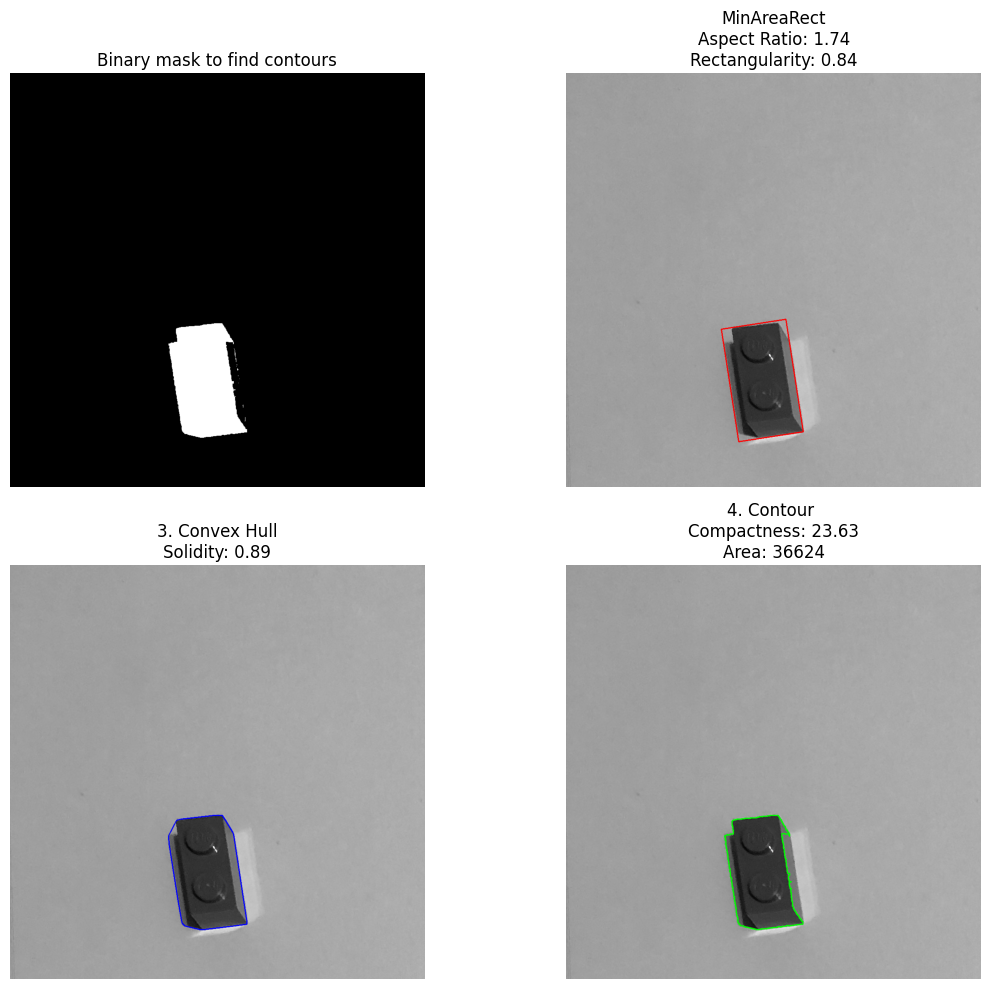

In [ ]:
def visualize_single_image_process(image_path):
    """
    Load one image and generates a visualization
    for the feature transformations
    """
    # Load image, grayscale, and turn to numpy array
    im = Image.open(image_path).convert('L')
    im_array = np.array(im)
    
    # Ensure lego blocks are white for OpenCV findContours to be able to detect blocks
    if im_array.dtype != np.uint8:
        im_array = im_array.astype(np.uint8)
    inv_im = cv2.bitwise_not(im_array)
    _, bi = cv2.threshold(inv_im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Ensure blocks are whole
    k = np.ones((5,5), np.uint8)
    bi = cv2.morphologyEx(bi, cv2.MORPH_CLOSE, k)
    
    # Outline lego blocks
    cntr, _ = cv2.findContours(bi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cntr:
        print("No contours found")
        return
    cnt = max(cntr, key=cv2.contourArea)
    
    # Colorize for better outline visualization
    c = cv2.cvtColor(im_array, cv2.COLOR_GRAY2BGR)
    c_rect = c.copy()
    c_hull = c.copy()
    c_cntr = c.copy()
    
    # Create rectangle
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int32(box)
    
    # Draw red rotated box
    cv2.drawContours(c_rect, [box], 0, (255, 0, 0), 2)
    
    # Calc values for display
    _, (width, height), _ = rect
    dims = sorted([width, height])
    aspect_ratio = dims[1] / dims[0] if dims[0] > 0 else 0
    rect_area = width * height
    obj_area = cv2.contourArea(cnt)
    rectangular = obj_area / rect_area if rect_area > 0 else 0

    hull = cv2.convexHull(cnt)
    
    # Draw blue hull
    cv2.drawContours(c_hull, [hull], -1, (0, 0, 255), 2)
    
    # Calc values
    hull_area = cv2.contourArea(hull)
    solid = obj_area / hull_area if hull_area > 0 else 0
    
    # Draw draw green contour
    cv2.drawContours(c_cntr, [cnt], -1, (0, 255, 0), 2)
    
    # Calc values
    perim = cv2.arcLength(cnt, True)
    compact = (perim**2) / obj_area if obj_area > 0 else 0

    # Plot
    _, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # plot for binary mask
    axes[0,0].imshow(bi, cmap='gray')
    axes[0,0].set_title("Binary mask to find contours")
    axes[0,0].axis('off')
    
    # plot for rotated rectangle
    axes[0,1].imshow(c_rect)
    axes[0,1].set_title(f"MinAreaRect\nAspect Ratio: {aspect_ratio:.2f}\nRectangularity: {rectangular:.2f}")
    axes[0,1].axis('off')
    
    # plot for solidity
    axes[1,0].imshow(c_hull)
    axes[1,0].set_title(f"3. Convex Hull\nSolidity: {solid:.2f}")
    axes[1,0].axis('off')
    
    # plot for compactness
    axes[1,1].imshow(c_cntr)
    axes[1,1].set_title(f"4. Contour \nCompactness: {compact:.2f}\nArea: {obj_area:.0f}")
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualization path for 1 image
sample_image_path = 'Lego_dataset_2/training/2025_01.jpg' 

# grab the first in the folder if no matching name
train_dir = 'Lego_dataset_2/training/'
if os.path.exists(train_dir):
    files = [f for f in os.listdir(train_dir) if f.endswith('jpg') or f.endswith('png')]
    if files:
        visualize_single_image_process(os.path.join(train_dir, files[0]))
    else:
        print("No images found in directory")
else:
    print("Directory not found")
